# Particles tracking eReefs Daily output

The [OceanParcels](http://oceanparcels.org) project develops `Parcels` (*Probably A Really Computationally Efficient Lagrangian Simulator*), a set of Python classes and methods to create customisable particle tracking simulations using output from Ocean Circulation models such as the eReefs one. 

Example https://tristansalles.github.io/EnviReef/6-addson/parcels.html

## Load the required Python libraries

First of all, load the necessary libraries:

In [23]:
import os
import numpy as np
import xarray as xr

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta
from operator import attrgetter

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

## Build multi-file dataset

Use the `open_mfdataset` function from `xArray` to open multiple netCDF files into a single xarray Dataset. 

Load the GBR1km dataset from the [NCI server](https://dapds00.nci.org.au/thredds/catalog/fx3/gbr1_2.0/catalog.html), so let's first define the base URL:

In [2]:
# For the hydro dataset
base_url = "https://dapds00.nci.org.au/thredds/dodsC/fx3/gbr1_2.0/gbr1_simple_"

In [3]:
day_st = 14     #Starting day
day_ed = 14     #Ending day
year = 2022   # Year
month = 5

# Based on the server the file naming convention 
hydrofiles = [f"{base_url}{year}-{month:02}-{day:02}.nc" for day in range(day_st, day_ed+1)]

### Clip the Dataset

To reduce the `Dataset` size we will clip the spatial extent based on longitudinal and latitudinal values. 

This is easely done using the `sel` function with the `slice` method.

In [20]:
ds_hydro_clip = ds_hydro.drop(['dhw0','dhw1','dhw2','dhw3','RT_expose','swr','temp_expose','salt','wspeed_u','wspeed_v'])

min_lon = 146     # lower left longitude
min_lat = -21     # lower left latitude
max_lon = 149     # upper right longitude
max_lat = -18     # upper right latitude
#min_depth = 42    # -0.5
#max_depth = 43    # 0.5

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]
#depth_bnds = [min_depth, max_depth]

# Performing the reduction and only taking the surface dataset (k=-1)
#ds_hydro_clip = ds_hydro_clip.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=42)
ds_hydro_clip = ds_hydro_clip.sel(j=slice(1000,1500), k=42) #monthly data
ds_hydro_clip

<xarray.Dataset>
Dimensions:    (j: 500, i: 510, time: 24)
Coordinates:
    zc         float64 dask.array<chunksize=(), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(500, 510), meta=np.ndarray>
    latitude   (j, i) float64 dask.array<chunksize=(500, 510), meta=np.ndarray>
  * time       (time) datetime64[ns] 2022-05-13T14:00:00 ... 2022-05-14T12:59...
Dimensions without coordinates: j, i
Data variables:
    botz       (j, i) float64 dask.array<chunksize=(500, 510), meta=np.ndarray>
    eta        (time, j, i) float32 dask.array<chunksize=(24, 500, 510), meta=np.ndarray>
    u          (time, j, i) float32 dask.array<chunksize=(24, 500, 510), meta=np.ndarray>
    v          (time, j, i) float32 dask.array<chunksize=(24, 500, 510), meta=np.ndarray>
    w          (time, j, i) float32 dask.array<chunksize=(24, 500, 510), meta=np.ndarray>
    temp       (time, j, i) float32 dask.array<chunksize=(24, 500, 510), meta=np.ndarray>
Attributes: (12/14)
    title:                           GBR1 Hydro
    description:                     eReefs GBR 1k grid with rivers. Uses JCU...
    paramhead:                       GBR 1km resolution grid
    paramfile:                       ./prm/gbr1_hydro_nrt.prm
    ems_version:                     v1.4.0 rev(6949)
    date_created:                    Wed May 18 15:11:59 2022
    ...                              ...
    Run_code:                        GBR1 Hydro|G0.00|H2.10|S0.00|B0.00
    Parameter_File_Revision:         $Revision$
    bald__isPrefixedBy:              prefix_list
    prefix_list_puv__:               https://w3id.org/env/puv#
    prefix_list_qudt__:              http://qudt.org/vocab/unit/
    DODS_EXTRA.Unlimited_Dimension:  time

In [8]:
data_name ='ereefdata_1gbr_May_2022.nc'
try:
     os.remove(data_name)
except OSError:
     pass

ds_hydro_clip.to_netcdf(path=data_name)

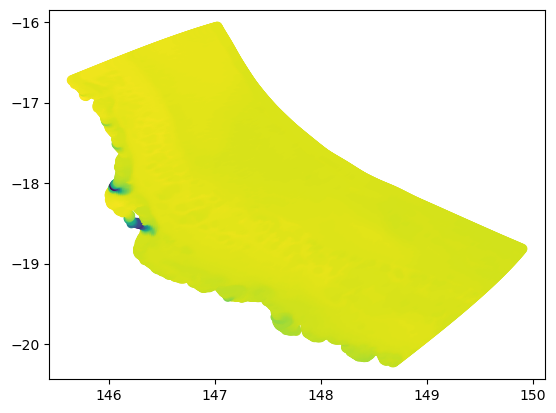

In [21]:
#Testing the domain

plt.scatter(ds_hydro_clip.longitude, ds_hydro_clip.latitude, c = ds_hydro_clip.temp[0,:,:])                                                       

## Reading velocities into Parcels

In [38]:
filenames = {'U': data_name,
             'V': data_name}

In [53]:
filenames = {'U': {'lon': 'mesh_mask.nc4',
                   'lat': 'mesh_mask.nc4',
                   'data': data_name},
             'V': {'lon': 'mesh_mask.nc4',
                   'lat': 'mesh_mask.nc4',
                   'data': data_name}}
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time'}
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

In [54]:
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 2389 and the array at index 1 has size 1021

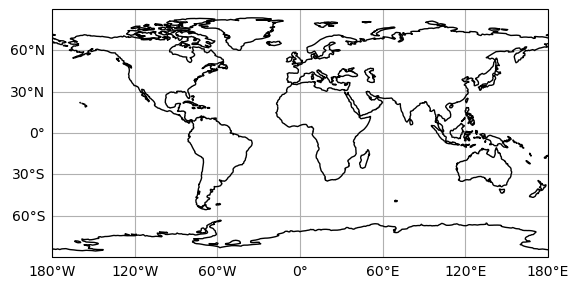

In [55]:
field_set.U.show()

In [47]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [48]:
npart = 10  # number of particles to be released
time = np.arange(0,npart)*timedelta(minutes=40).total_seconds()  # release every particle in a delayed mode

In [49]:
pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=JITParticle,
                             size=npart,             # releasing X particles
                             start=(147.5, -19.5),   # releasing on a line: the start longitude and latitude
                             finish=(148.0, -19.0),
                             time=time)  # release every particle X hour

NameError: name 'fieldset' is not defined